In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
import keras
import tensorflow
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [2]:
from google.colab import files  
uploaded = files.upload()

Saving NIFTY50 - NIFTY50.csv to NIFTY50 - NIFTY50.csv


In [5]:
import io
Data=pd.read_csv(io.BytesIO(uploaded['NIFTY50 - NIFTY50.csv']))

In [6]:
cols= list(Data)[1:5]
stock_prices = Data[cols].astype(float)

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(stock_prices)
stock_prices_scaled = scaler.transform(stock_prices)
print('df_for_training_scaled shape == {}.'.format(stock_prices_scaled.shape))

df_for_training_scaled shape == (3326, 4).


In [8]:
train_size = int(len(stock_prices_scaled) * 0.66)
test_size = len(stock_prices_scaled) - train_size
train, test = stock_prices_scaled[0:train_size,:], stock_prices_scaled[train_size:len(stock_prices_scaled),:]


In [9]:
train_inputs = []
train_closing_labels=[]

In [10]:
n_future = 1   # Number of days we want to predict into the future
n_past = 14   # Number of past days we want to use to predict the future
for i in range(n_past, len(train) - n_future +1):
    train_inputs.append(train[i - n_past:i, 0:train.shape[1]])
    #train_opening_labels.append(train[i + n_future - 1:i + n_future, 0])
    train_closing_labels.append(train[i + n_future - 1:i + n_future, 1])
train_inputs, train_closing_labels = np.array(train_inputs), np.array(train_closing_labels)


In [11]:
print('train_input shape == {}.'.format(train_inputs.shape))
print('train_closing shape == {}.'.format(train_closing_labels.shape))

train_input shape == (2181, 14, 4).
train_closing shape == (2181, 1).


In [12]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(train_inputs.shape[1], train_inputs.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(train_closing_labels.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                17664     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 17,729
Trainable params: 17,729
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(train_inputs, train_closing_labels, epochs = 100, validation_data = (train_inputs, train_closing_labels), batch_size = 32, verbose=1)

Epoch 1/100
69/69 [==============================] - 3s 21ms/step - loss: 0.2793 - val_loss: 0.0043
Epoch 2/100
69/69 [==============================] - 1s 10ms/step - loss: 0.0125 - val_loss: 0.0021
Epoch 3/100
69/69 [==============================] - 1s 11ms/step - loss: 0.0113 - val_loss: 0.0029
Epoch 4/100
69/69 [==============================] - 1s 10ms/step - loss: 0.0114 - val_loss: 0.0025
Epoch 5/100
69/69 [==============================] - 1s 10ms/step - loss: 0.0101 - val_loss: 0.0027
Epoch 6/100
69/69 [==============================] - 1s 10ms/step - loss: 0.0104 - val_loss: 0.0015
Epoch 7/100
69/69 [==============================] - 1s 11ms/step - loss: 0.0101 - val_loss: 0.0018
Epoch 8/100
69/69 [==============================] - 1s 11ms/step - loss: 0.0098 - val_loss: 0.0023
Epoch 9/100
69/69 [==============================] - 1s 11ms/step - loss: 0.0081 - val_loss: 0.0016
Epoch 10/100
69/69 [==============================] - 1s 11ms/step - loss: 0.0094 - val_loss: 0.0013

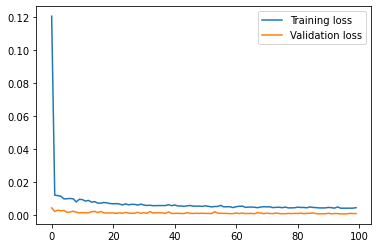

In [14]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [15]:
training_data_prediction= model.predict(train_inputs) 
training_data_prediction

array([[-0.84916234],
       [-0.8731295 ],
       [-0.85767186],
       ...,
       [ 0.39320412],
       [ 0.39939097],
       [ 0.39522448]], dtype=float32)

In [16]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 4 times and discard them after inverse transform
forecast_copies_1 = np.repeat(training_data_prediction, train.shape[1], axis=-1)
predicted_train = scaler.inverse_transform(forecast_copies_1)[:,0]
predicted_train

array([5253.5474, 5186.7036, 5229.8145, ..., 8718.459 , 8735.714 ,
       8724.094 ], dtype=float32)

In [17]:
Train_data=Data[n_past:train_size]
Train_data['Date']=pd.to_datetime(Train_data['Date'])
training_forecast = pd.DataFrame( {'Date':Train_data['Date'],'Close':Train_data['Close'],'Forecast':predicted_train})
train_graph=training_forecast.set_index('Date')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


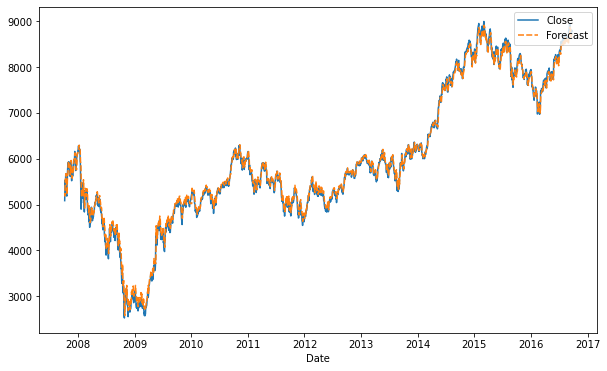

In [18]:
line,ax = plt.subplots(figsize=(10,6))
ax = sns.lineplot(data=train_graph)
ax.legend (loc="upper right")

In [19]:
import math
trainScore = math.sqrt(mean_squared_error(train_graph['Close'], train_graph['Forecast']))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 102.06 RMSE


In [20]:
test_inputs=[]
for i in range(n_past, len(test) - n_future +1):
    test_inputs.append(test[i - n_past:i, 0:train.shape[1]])
test_inputs=np.array(test_inputs)

In [21]:
testing_data_prediction= model.predict(test_inputs) 
forecast_copies_2 = np.repeat(testing_data_prediction, test.shape[1], axis=-1)
predicted_test = scaler.inverse_transform(forecast_copies_2)[:,0]

In [22]:
Test_data=Data[train_size+n_past:len(stock_prices_scaled)]
Test_data['Date']=pd.to_datetime(Test_data['Date'])
testing_forecast = pd.DataFrame( {'Date':Test_data['Date'],'Close':Test_data['Close'],'Forecast':predicted_test})
test_graph=testing_forecast.set_index('Date')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


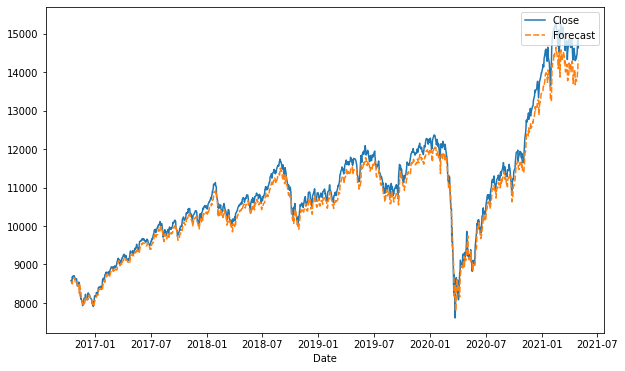

In [23]:
line,ax = plt.subplots(figsize=(10,6))
ax = sns.lineplot(data=test_graph)
ax.legend (loc="upper right")

In [24]:
import math
testScore = math.sqrt(mean_squared_error(test_graph['Close'], test_graph['Forecast']))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 278.97 RMSE
